# We are going to setup TOTAL using a simplified example based on the datasets from the PUMML publication

In [1]:
import os 
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import horovod.tensorflow.keras as hvd
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import argparse
import h5py as h5
import utils
import matplotlib.pyplot as plt
from ABCNet import ABCNet, SWD
hvd.init()

In [2]:
#Loading datasets and applying a simple preprocessing
config_file = 'config_dev.json' #store some training info
dataset_config = utils.LoadJson(config_file)
NSWD = dataset_config['NSWD'] #SWD is calculated considering only NSWD features
NPART=dataset_config['NPART'] #maximum number of particles considered

In [3]:
data,label,_ = utils.preprocessing(os.path.join('/global/cfs/cdirs/m3246/vmikuni/PU',dataset_config['FILES']),nparts=NPART)
frac = 0.8 #fraction of events used for training
data_size = data.shape[0]
data_label = data[:,:,:NSWD].copy() #data with pileup used in the loss function to compare with label; the data without pileup
dataset = tf.data.Dataset.from_tensor_slices((data,np.concatenate([data_label,label[:,:,:NSWD]],-1)))
train_data, test_data = utils.split_data(dataset,data_size,frac)
del dataset, data, label, data_label


2023-01-28 11:56:55.775250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 11:56:57.628148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38277 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-01-28 11:56:57.629413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38277 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-01-28 11:56:57.631390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [4]:
BATCH_SIZE = dataset_config['BATCH']
LR = float(dataset_config['LR'])
NUM_EPOCHS = dataset_config['MAXEPOCH']
EARLY_STOP = dataset_config['EARLYSTOP']
checkpoint_folder = 'checkpoints_{}/checkpoint'.format(dataset_config['CHECKPOINT_NAME'])

In [5]:
inputs,outputs = ABCNet(npoint=NPART,nfeat=dataset_config['SHAPE'][2])
model = Model(inputs=inputs,outputs=outputs)
opt = keras.optimizers.Adam(learning_rate=LR)
opt = hvd.DistributedOptimizer(
    opt, average_aggregated_gradients=True)
model.compile(loss=SWD,
              optimizer=opt,experimental_run_tf_function=False)
    
callbacks = [
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),
    hvd.callbacks.MetricAverageCallback(),            
    ReduceLROnPlateau(patience=10, 
                      min_lr=1e-8,verbose=hvd.rank()==0),
    EarlyStopping(patience=EARLY_STOP,restore_best_weights=True),
    ]

if hvd.rank()==0:
    checkpoint = ModelCheckpoint(checkpoint_folder,save_best_only=True,mode='auto',
                                 period=1,save_weights_only=True)
        
    callbacks.append(checkpoint)
    print(model.summary())
    
load=False
if load:
    model.load_weights(checkpoint_folder)
else:
    history = model.fit(
        train_data.batch(BATCH_SIZE),
        epochs=NUM_EPOCHS,
        steps_per_epoch=int(data_size*frac/BATCH_SIZE),
        # steps_per_epoch=1,
        validation_data=test_data.batch(BATCH_SIZE),
        validation_steps=int(data_size*(1-frac)/BATCH_SIZE),
        verbose=1 if hvd.rank()==0 else 0,
        callbacks=callbacks
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 6)]    0           []                               
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 1000, 3)     0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 1000, 2)     0           ['tf.__operators__.getitem_3[0][0
 icingOpLambda)                                                  ]']                              
                                                                                              

2023-01-28 11:57:03.100933: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


6/6 [==============================] - 10s 634ms/step - loss: 148.1756 - val_loss: 445.8336 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 3s 548ms/step - loss: 11.8825 - val_loss: 416.9179 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 3s 544ms/step - loss: 9.4551 - val_loss: 388.4260 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 3s 547ms/step - loss: 8.0548 - val_loss: 368.8071 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 3s 546ms/step - loss: 7.0948 - val_loss: 349.5662 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 3s 545ms/step - loss: 6.6497 - val_loss: 329.9316 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 3s 546ms/step - loss: 6.2904 - val_loss: 322.3268 - lr: 0.0010
Epoch 8/200
6/6 [==============================] - 3s 545ms/step - loss: 6.1170 - val_loss: 306.6929 - lr: 0.0010
Epoch 9/200
6/6 [==============================] - 3s 545ms/step - loss: 5.8217 - val_loss: 302.

# Let's plot the jet pt resolution and compare with PUPPI

In [6]:
import importlib
importlib.reload(utils)
data,nopu,jet_info = utils.preprocessing(os.path.join('/global/cfs/cdirs/m3246/vmikuni/PU',dataset_config['FILES']),nparts=NPART)
total_weights = model.predict(data,batch_size=200)
puppi_weights = np.expand_dims(data[:,:,4],-1)
data = utils.convert_preprocessing(data) #undo data preprocessing to calculate jet resolution
nopu = utils.convert_preprocessing(nopu)


10/10 [==============================] - 2s 151ms/step


(array([ 39.,  28.,  64.,  61.,  54., 105., 107., 126.,  99., 140., 156.,
        168., 170., 174., 147., 103.,  82.,  47.,  37.]),
 array([100., 110., 120., 130., 140., 150., 160., 170., 180., 190., 200.,
        210., 220., 230., 240., 250., 260., 270., 280., 290.]),
 <BarContainer object of 19 artists>)

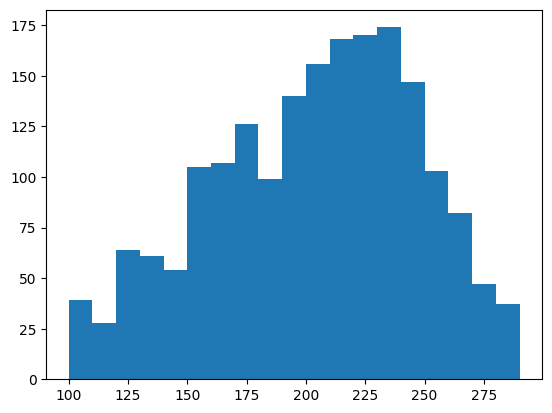

In [7]:
#Look only at the leading jet for simplicity
mask_jet1 = jet_info==0
px,py,pz=utils.convert_coordinate(nopu[:,:,:4],mask_jet1)

jet_pt_truth = np.sum(np.sqrt(px**2+py**2),1)[:,0]
plt.hist(jet_pt_truth,bins=np.arange(100, 300, 10))

In [8]:
px,py,pz=utils.convert_coordinate(data[:,:,:4],mask_jet1)
jet_pt_total = np.sum(np.sqrt(px**2+py**2)*(total_weights),1)[:,0]
jet_pt_puppi = np.sum(np.sqrt(px**2+py**2)*(puppi_weights),1)[:,0]
res_total = 100*(jet_pt_truth-jet_pt_total)/jet_pt_truth
res_puppi = 100*(jet_pt_truth-jet_pt_puppi)/jet_pt_truth

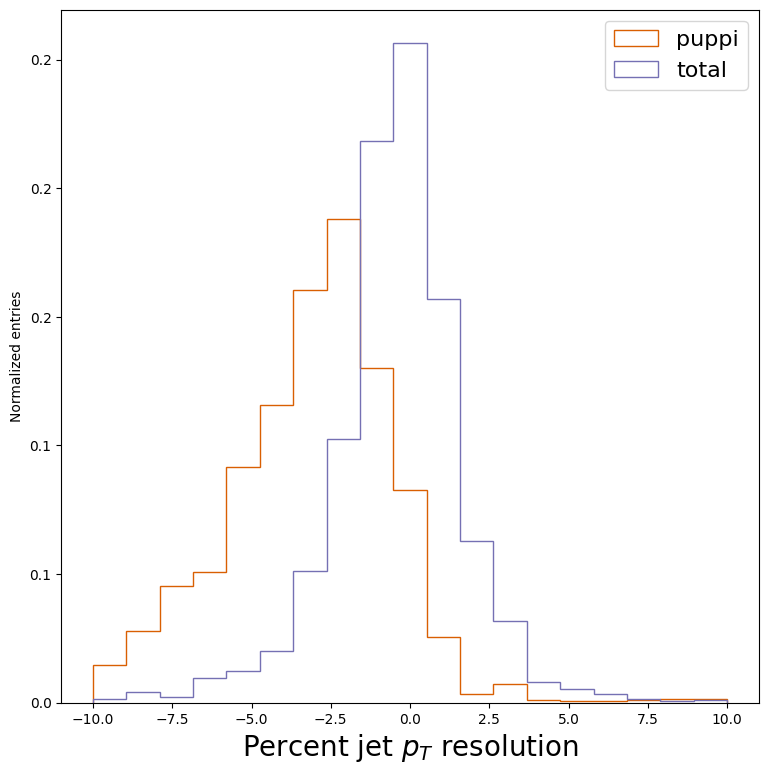

In [9]:
binning = np.linspace(-10,10,20)

label_names = {
        'puppi': 'puppi',
        'abc': 'total',
}
feed_dict = {
        'puppi': res_puppi,
        'abc': res_total,
}

fig,ax0 = utils.HistRoutine(feed_dict,xlabel=r'Percent jet $p_T$ resolution',
                            ylabel= 'Normalized entries',plot_ratio=False,binning=binning,
                            label_names=label_names)

